# Проект "Компьюбтер говорит "нет".  

РЕКОМЕНДАЦИИ ПО ВЫПОЛНЕНИЮ ПРОЕКТА

* Добавьте новые данные в исходный датасет.
* Сделайте разведку новых признаков аналогично предыдущим. Используйте визуализацию, поиск уникальных значений, очистку и поиск выбросов там, где это необходимо.
* Включите новые признаки в анализ основных переменных, оцените их важность и вклад для модели, подумайте над тем, можно ли сгенерировать новые признаки на основе добавленных
* Получите новое значение ROC AUC для новой модели и попробуйте улучшить ее результаты на основе подбора параметра регуляризации
* Чтобы понять, к какому уровню вам стоит стремиться, достаточно взглянуть на таблицу лидеров соревнования.  


КРИТЕРИИ ОЦЕНКИ

Вот по каким критериям проект будет оценивать ментор:

* Качество кода (соблюдение стандартов оформления pep-8, комментирование кода, наличие выводов ). Оформление проекта на Github— 3 балла.
* Качество разведывательного анализа данных (визуализация, очистка данных, работа с выбросами) — 3 балла.
* Работа с признаками (выбор признаков, генерация новых признаков) — 3 балла.
* Качество решения: Результат метрики ROC AUC — 3 балла.
* Качество решения: обоснованность выводов и общая логика решения — 3 балла.
* Работа в команде — 3 балла.
* Настройка гиперпараметров — 3 балла.
* Работа сдана к дедлайну — 3 балла. 
* За каждый критерий можно получить от 0 до 3 баллов. 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, mean_squared_error, \
                            precision_score, recall_score, f1_score, accuracy_score, plot_confusion_matrix, \
                            classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures, PolynomialFeatures
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

## Загрузка и первичный осмотр датасета

In [3]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requiremnts.txt

# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [4]:
# считаем сами данные из предоставленного набора
path = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(path+'train.csv', encoding = 'ISO-8859-1', low_memory = False)
df_test = pd.read_csv(path+"test.csv", encoding = 'ISO-8859-1', low_memory = False)
submission = pd.read_csv(path+'sample_submission.csv', encoding = 'ISO-8859-1', low_memory = False)

Посмотрим на данные: <br>
<table align="left">
<tr ><th>Имя признака</th><th>Значение признака</th></tr> <!--ряд с ячейками заголовков-->
    <tr><td>client_id</td><td>идентификатор клиента</td></tr> <!--ряд с ячейками тела таблицы-->
    <tr><td>education</td><td>уровень образования</td></tr> <!--ряд с ячейками тела таблицы-->
    <tr><td>sex</td><td>пол заёмщика</td></tr> <!--ряд с ячейками тела таблицы-->
    <tr><td>age</td><td>возраст заёмщика</td></tr> <!--ряд с ячейками тела таблицы-->
    <tr><td>car</td><td>флаг наличия автомобиля</td></tr> <!--ряд с ячейками тела таблицы-->
    <tr><td>car_type</td><td>флаг автомобиля-иномарки</td></tr> <!--ряд с ячейками тела таблицы-->
    <tr><td>decline_app_cnt</td><td>количество отказанных прошлых заявок</td></tr> <!--ряд с ячейками тела таблицы-->
    <tr><td>good_work</td><td>флаг наличия «хорошей» работы</td></tr> <!--ряд с ячейками тела таблицы-->
    <tr><td>bki_request_cnt</td><td>количество запросов в БКИ</td></tr> <!--ряд с ячейками тела таблицы-->
    <tr><td>home_address</td><td>категоризатор домашнего адреса</td></tr> <!--ряд с ячейками тела таблицы-->
    <tr><td>work_address</td><td>категоризатор рабочего адреса</td></tr> <!--ряд с ячейками тела таблицы-->
    <tr><td>income</td><td>доход заёмщика</td></tr> <!--ряд с ячейками тела таблицы-->
    <tr><td>foreign_passport</td><td>наличие загранпаспорта</td></tr> <!--ряд с ячейками тела таблицы-->
    <tr><td>default</td><td>наличие дефолта</td></tr> <!--ряд с ячейками тела таблицы-->
</table>
    <br>

In [5]:
print("### Посмотрим на данные для обучения ###############\n")
print(df_train.info())
print("### Посмотрим на тестовые данные ###################\n")
print(df_test.info())

### Посмотрим на данные для обучения ###############

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null 

In [6]:
print("### Посмотрим на сами данные для обучения ###############\n")
df_train.sample(5)

### Посмотрим на сами данные для обучения ###############



,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
45130,82107,30MAR2014,GRD,M,48,N,N,0,0,-1.853672,2,80,2,3,80000,1,3,Y,0
65011,89942,06APR2014,UGR,M,24,N,N,0,1,-1.563058,2,70,2,3,30000,1,3,N,0
19823,78261,26MAR2014,GRD,M,26,N,N,0,0,-1.569614,1,60,1,2,150000,2,2,Y,0
32812,3815,10JAN2014,SCH,F,60,N,N,0,0,-1.767709,1,50,2,3,6000,3,1,N,0
31563,95920,12APR2014,GRD,F,59,N,N,0,0,-1.673738,1,50,2,3,15000,3,2,N,0


## Предобработка данных

In [7]:
def get_stats(df):
    # df - датафрейм по которому собираем статистику describe()
    # df_ret - на выходе получаем объединенный датафрейм
    
    
    df_info=df.agg({lambda x: x.unique()[:7]})\
        .append(pd.Series(df.dtypes, name='type_field'))\
        .append(pd.Series(df.nunique(), name='nunique'))\
        .append(pd.Series(df.isnull().sum(), name='not_fill_number'))\
        .transpose()
    
    df_info=df_info.rename(columns={'<lambda>': 'unique7'})

    df_info=pd.merge(names,df_info,how='outer', left_index=True, right_index=True)

    # добавим значения функции describe()
    df_2=df.describe().T
    df_ret=pd.merge(df_info,df_2,how='outer',left_index=True, right_index=True).fillna("")
    
    
    # добавим наиболее часто встречающееся значение у признака
    fb=[]
    for i in range(0,len(df.columns)):
        fb.append([df.columns[i],df.value_counts().index[0][i]])

    fb=pd.DataFrame(fb).set_index(0).rename(columns={1:'most_freq_value'})
    
    #теперь добавим в нашу финальную таблицу
    df_ret=pd.merge(df_ret,fb,how='outer',left_index=True, right_index=True).fillna("")

    return df_ret

In [8]:
def chk_cats_distribution():
    return set(data.columns)-set(bin_cols)-set(cat_cols)-set(num_cols)

def list_cats():
    print('Бинарные признаки (bin_cols):',bin_cols)
    print('Категориальные признаки (cat_cols):',cat_cols)
    print('Численные признаки (num_cols):',num_cols)

In [9]:
def pred_processing(flag=0):
    # flag - используется для построения наивеной модели (те без генерации новых признаков)
    # соответственно, чтобы не писать вторую функцию (с генерацией новых признаков), я сделал флаг
    
    print(datetime.datetime.now(),', pred_processing:','старт выполнения функции')
    
    # загрузим исходные данные
    path = '/kaggle/input/sf-dst-scoring/'
    df_train = pd.read_csv(path+'train.csv', encoding = 'ISO-8859-1', low_memory = False)
    df_test = pd.read_csv(path+"test.csv", encoding = 'ISO-8859-1', low_memory = False)
    
    # подгрузим мой файл с описание признаков данных     
    names = pd.read_csv('../input/namesofcats/'+'/names.csv',sep=';')
    # сделаем индексом столбец с названиями столбцов
    names=names.set_index('Имя признака')

    print(datetime.datetime.now(),', pred_processing:','данные загружены')
    
    # для предобработки данных объединим наборы данных (перед передаче модели на обучение мы разделим их обратно)
    # для этого добавим столбец sample
    df_train['sample'] = 1 # 1 - из обучающего набора данных
    df_test['sample'] = 0 # 0 - из тестового
    # для корректного объединения наборов надо добавить столбец в тестовый нобар (поставлю значение 999)
    df_test['default'] = 999 

    # теперь объединим наборы
    data = df_test.append(df_train, sort=False).reset_index(drop=True)
    print(datetime.datetime.now(),', pred_processing:','данные объединены')
        
    # переведем дату в формат даты
    data['app_date'] = pd.to_datetime(data['app_date'], format="%d%b%Y")
    print(datetime.datetime.now(),', pred_processing:','формат даты изменен')
    
    # заполним пропуски в признаке "education"
    # Получается у нас 478 пропусков из 110148 строчек, что является 0.4% от данных. 
    # Так что число технически можно совершенно спокойно их удалить.
    # Но я поступлю иначе создам новый признак, указывающий был ли заполнен в исходных
    # данных этот признак, а всем пропускам присвою минимальное образование - в нашем 
    # случае это SCH (школа). Что в общем то логично, банки конечно могут выдавать людям 
    # кредиты без образования вообще, но тогда риск невозврата повышается многократно, 
    # поэтому логично, что такие "клиенты" отсекаются в самом начале. 
    # И присвоить пропускам значение школы в общем кажется правильной идеей.
    
    if flag!=0:
        # добавим признак заполненности в исходном массиве
        data['ed_fill']=data.education.apply(lambda x: 0 if pd.isna(x)==True else 1)
    
    # заменим пропущенные значения на SCH
    data.education.fillna('SCH', inplace=True)
    print(datetime.datetime.now(),', pred_processing:','заполнены пропуски в признаке education')
    
    # созданим списки по типам данных в нашем наборе
    # бинарные признаки
    bin_cols=['sex','car', 'car_type', 'foreign_passport', 'good_work']
    # категориальные признаки
    cat_cols=['home_address', 'work_address','education','first_time','sna','region_rating']
    # количественные признаки
    num_cols=['age','decline_app_cnt','income','bki_request_cnt','score_bki','days_ago','days_from']
    print(datetime.datetime.now(),', pred_processing:','созданы списки признаков')
    
    # проверим на пропущенные признаки при забиении по типам признаков
#     list_not_distributed=chk_cats_distribution()
    print(datetime.datetime.now(),', pred_processing:',"Нераспределенные признаки по спискам:",set(data.columns)-set(bin_cols)-set(cat_cols)-set(num_cols))
    
    # сделаем проверку на дублирование строчек
    dubl=data[data.duplicated(['client_id'], keep=False)]
    print(datetime.datetime.now(),', pred_processing:','количество дублей в данных:', len(dubl))
    
    print(datetime.datetime.now(),', pred_processing:','конец выполнения функции')
    
    return data,bin_cols,cat_cols,num_cols,names

In [10]:
# функция кодирования бинарных признаков
def pred_processing_encoding(data,bin_cols,flag=0):
    label_encoder = LabelEncoder()
    for item in bin_cols:
        data[item] = label_encoder.fit_transform(data[item])   
    
    print(datetime.datetime.now(),', pred_processing_encoding:','бинарные признаки закодированы')
    
    if flag!=0:
        # посмотрим на результат
        data[bin_cols].sample(5)
    
    return data

# --------------------------------------------------------------------------------------------------

# функция по созданию dummy-переменных для категориальных признаков
# функция возвращает dataframe и список новых категориальных (уже бинарных) полей
def convert_to_dummies(data,cat_cols):
    data_dumm=pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)
    cat_cols2=set(data_dumm.columns)-set(data.columns)
    print(datetime.datetime.now(),', convert_to_dummies:','создание dummy-переменных закончено')
    return data_dumm,cat_cols2

# --------------------------------------------------------------------------------------------------

# функция отбора признаков для модели
# результат - список признаков для моделирования
def choose_cats(bin_cols,cat_cols,num_cols,border=0.001,flag=0):
    # отберем признаки в модель по следующему признаку - 
    # если значимость признака выше 0,001 то признак идет в модель, иначе нет.
    
    # посчитаем значимости для бинарных и категориальных признаков    
    bin_cat = pd.Series(mutual_info_classif(data[data['sample']==1][bin_cols], data[data['sample']==1]['default'],
                                    discrete_features =True), index = bin_cols)
    cat_cat = pd.Series(mutual_info_classif(data[data['sample']==1][cat_cols], data[data['sample']==1]['default'],
                                    discrete_features =True), index = cat_cols)
    
    # сначала отберем бинарные признаки
    to_model_bin_cat=bin_cat[bin_cat>=border].index.to_list()

    # теперь категориальные
    to_model_cat_cat=cat_cat[cat_cat>=border].index.to_list()

    # список численных признаков num_cols я оставил без изменений (они все идут в модель)

    # составим финальный список признаков идущих в модель
    cats_to_model=num_cols + to_model_bin_cat + to_model_cat_cat
    print(datetime.datetime.now(),', choose_cats:','создание списка признаков для модели завершено')
    
    # вот и пригодился флаг - это для вывода информационных сообщений     
    if flag!=0:
        print('бинарные признаки идущие в модель:\n',to_model_bin_cat)
        print('категориальные признаки идущие в модель:\n',to_model_cat_cat)       
        print('\nфинальный список признаков идущих в модель:\n',cats_to_model)
        
    return cats_to_model


def data_separation(data):
    # разделим обратно данные на тестовую и обучающую части
    train_df = data.query('sample == 1').drop(['sample','app_date'], axis=1)
    test_df = data.query('sample == 0').drop(['sample'], axis=1)
    
    # Выделим целевую переменную из train датасета
    X = train_df.drop(['default'], axis=1).values
    Y = train_df['default'].values 
    
    print(datetime.datetime.now(),', data_separation:','X,Y - созданы')
    return X,Y

## построим наивную модель

In [78]:
# собственные функции

# Функция для графического построения confusion matrix
def CalcConfusionMatrix(y_test, pred):
    label_true_class='Истинный класс'
    label_pred_class='Предсказанный класс'
    
    matrix = confusion_matrix(y_test, pred)
    norm_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#   почему то вариант ниже (где нормализация штатными средствами) не совпадает с математикой((( 
#     norm_matrix = confusion_matrix(y_test, pred,normalize='pred')
    
    # нарисуем саму матрицу
    fig,ax = plt.subplots(ncols=2, nrows=1, figsize=(9,4), constrained_layout=True)
    # Нормализованные значения
    sns.heatmap(norm_matrix, cmap='coolwarm_r',fmt=".2f",#square=True,
                linewidths=0.5, annot=True,ax=ax[0])
    ax[0].set_title('Нормализованные значения')
    ax[0].set_ylabel(label_true_class)
    ax[0].set_xlabel(label_pred_class)
    # и Абсолютные значения
    sns.heatmap(matrix, cmap='coolwarm_r', fmt="d",#square=True,
                linewidths=0.5, annot=True,ax=ax[1])
    ax[1].set_title('Абсолютные значения')
    ax[1].set_ylabel(label_true_class)
    ax[1].set_xlabel(label_pred_class)
    
    plt.show()

# --------------------------------------------------------------------------------------------------

# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    
#     print('##############################################################')
#     print(np.shape(X_train))
#     print(np.shape(x_test))
#     print(np.shape(y_train))
#     print(np.shape(y_test))
#     print('##############################################################')
    
#     probs = model.predict_proba(X_test)
#     probs=probs[:,1]
#     pred = model.predict(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

# --------------------------------------------------------------------------------------------------

# объединенная функция по выводу результатов моделирования
def result_modelling(y_test,pred):
    print('\n### Confusion matrix ###############################################\n')
    
    # построим Confusion matrix
    CalcConfusionMatrix(y_test,pred)
    
    # выведем дополнительно
    print('### Classification Report ##########################################\n')
    print(classification_report(y_test, pred, labels=np.unique(pred)))
    print('####################################################################')
    
    # построим ROC-кривую и посчитаем AUC
    calc_and_plot_roc(y_test, pred)

In [12]:
data,bin_cols,cat_cols,num_cols,names = pred_processing()
data = pred_processing_encoding(data,bin_cols)
data,cat_cols = convert_to_dummies(data,cat_cols)
cats_to_model = choose_cats(bin_cols,cat_cols,num_cols)
X,Y = data_separation(data)

2021-09-15 06:42:28.347179 , pred_processing: старт выполнения функции
2021-09-15 06:42:28.595100 , pred_processing: данные загружены
2021-09-15 06:42:28.655202 , pred_processing: данные объединены
2021-09-15 06:42:28.686045 , pred_processing: формат даты изменен
2021-09-15 06:42:28.699830 , pred_processing: заполнены пропуски в признаке education
2021-09-15 06:42:28.700159 , pred_processing: созданы списки признаков
2021-09-15 06:42:28.700209 , pred_processing: Нераспределенные признаки по спискам: {'sample', 'app_date', 'client_id', 'default'}
2021-09-15 06:42:28.710969 , pred_processing: количество дублей в данных: 0
2021-09-15 06:42:28.711156 , pred_processing: конец выполнения функции
2021-09-15 06:42:28.873747 , pred_processing_encoding: бинарные признаки закодированы
2021-09-15 06:42:28.918298 , convert_to_dummies: создание dummy-переменных закончено
2021-09-15 06:42:29.255982 , choose_cats: создание списка признаков для модели завершено
2021-09-15 06:42:29.293885 , data_separat


### Confusion matrix ###############################################



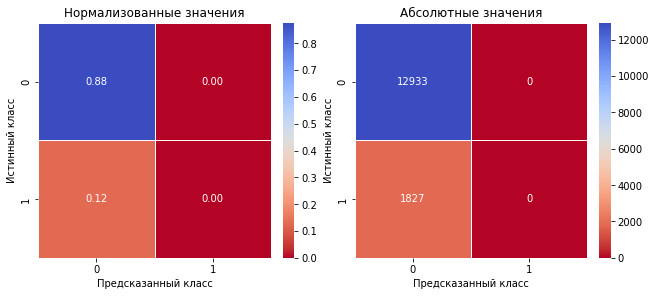

### Classification Report ##########################################

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12933

   micro avg       0.88      1.00      0.93     12933
   macro avg       0.88      1.00      0.93     12933
weighted avg       0.88      1.00      0.93     12933

####################################################################


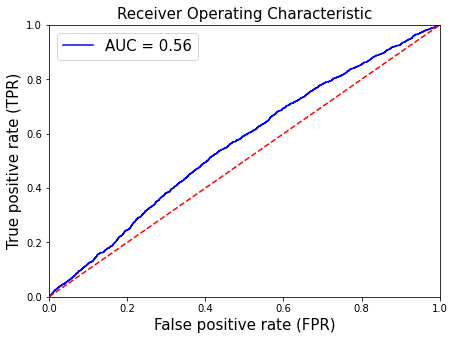

In [13]:
# переходим к наивной модели

# разделим данные
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED)

model = LogisticRegression(max_iter=500, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:,1]
pred = model.predict(X_test)

# выведем результаты моделирования
result_modelling(y_test,pred)

даже наивная модель оказалась лучше простого угадывания))  
теперь у меня есть метрика которую надо улучшить.  
приступим

## Работаем с признаками

In [14]:
# загрузим и предобработаем данные заново
data,bin_cols,cat_cols,num_cols,names = pred_processing()

2021-09-15 06:42:50.675446 , pred_processing: старт выполнения функции
2021-09-15 06:42:50.937589 , pred_processing: данные загружены
2021-09-15 06:42:50.985008 , pred_processing: данные объединены
2021-09-15 06:42:51.011694 , pred_processing: формат даты изменен
2021-09-15 06:42:51.025303 , pred_processing: заполнены пропуски в признаке education
2021-09-15 06:42:51.025456 , pred_processing: созданы списки признаков
2021-09-15 06:42:51.025574 , pred_processing: Нераспределенные признаки по спискам: {'sample', 'app_date', 'client_id', 'default'}
2021-09-15 06:42:51.037003 , pred_processing: количество дублей в данных: 0
2021-09-15 06:42:51.037207 , pred_processing: конец выполнения функции


In [15]:
dt=pd.DataFrame(data[(data['default']!=999)&(data['sample']==1)].groupby(['app_date','default'], as_index=False)['client_id'].count())
dt.rename(columns={'client_id':'count'},inplace=True)
dt

,app_date,default,count
0,2014-01-01,0,37
1,2014-01-01,1,6
2,2014-01-02,0,119
3,2014-01-02,1,18
4,2014-01-03,0,169
...,...,...,...
235,2014-04-28,1,53
236,2014-04-29,0,338
237,2014-04-29,1,34
238,2014-04-30,0,521


In [16]:
columns_calc = ['data','num_default_customers','num_nondefault_customers','proportion_customers']
calc_proportion_customers_df=pd.DataFrame(data=None, columns=columns_calc)

for item in dt.app_date.unique():
    num_default_customers=dt[(dt['app_date']==item)&(dt['default']==1)].iloc[0]['count']
    num_nondefault_customers=dt[(dt['app_date']==item)&(dt['default']==0)].iloc[0]['count']
    proportion_customers=round(num_default_customers/(num_nondefault_customers+num_default_customers)*100 ,2)
    d={'data':item,'num_default_customers':num_default_customers,'num_nondefault_customers':num_nondefault_customers,'proportion_customers':proportion_customers}
    calc_proportion_customers_df = calc_proportion_customers_df.append(d, ignore_index=True)

calc_proportion_customers_df=calc_proportion_customers_df.sort_values(by='data')

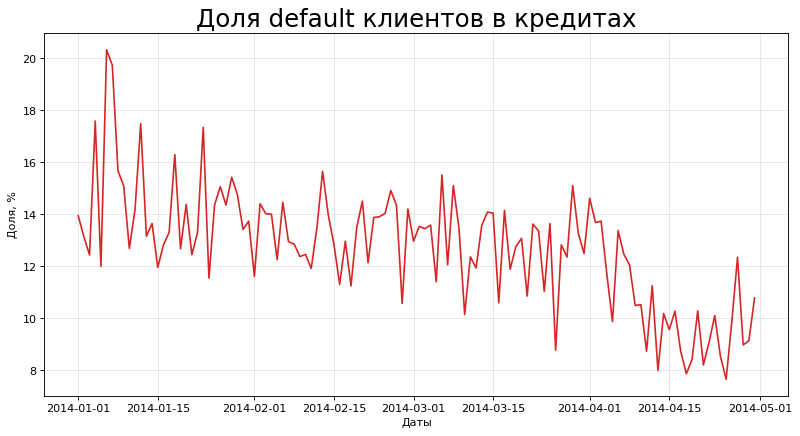

In [17]:
plt.figure(figsize=(12,6), dpi= 80)
plt.plot('data', 'proportion_customers', data=calc_proportion_customers_df, color='tab:red')
plt.title("Доля default клиентов в кредитах", fontsize=22)
plt.ylabel("Доля, %")
plt.xlabel("Даты")
plt.grid(axis='both', alpha=.3)

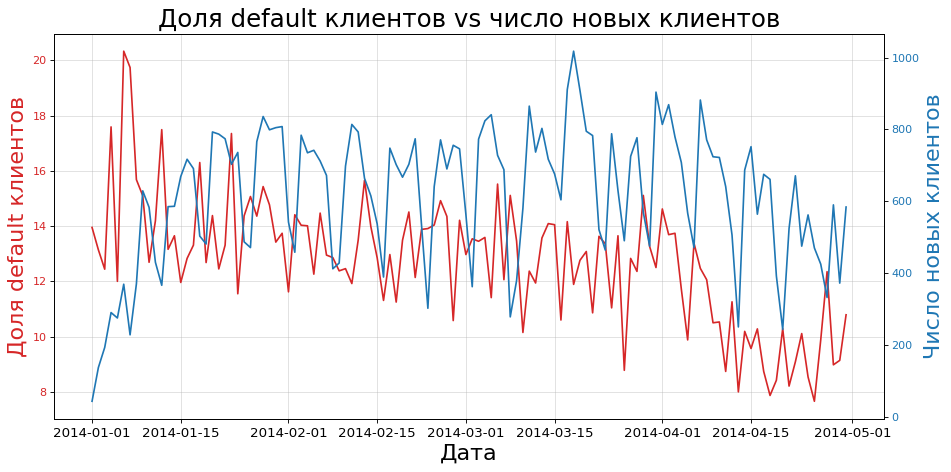

In [18]:
x = calc_proportion_customers_df['data']
y1 = calc_proportion_customers_df['proportion_customers']
y2 = calc_proportion_customers_df['num_nondefault_customers'] + calc_proportion_customers_df['num_default_customers']

fig, ax1 = plt.subplots(1,1,figsize=(12,6), dpi= 80)
ax1.plot(x, y1, color='tab:red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Дата', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('Доля default клиентов', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Число новых клиентов", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title("Доля default клиентов vs число новых клиентов", fontsize=22)
fig.tight_layout()
plt.show()

Доля плохих клиентов падает со временем, при том что число клиентов падает - это хорошо.  
Подозрительно выглядят провалы по выдачам кредитов и одновременный рост плохих клиентов на графике.  
Есть подозрения, что это выходные дни и хорошие сотруднике на отдыхе, а вот тот кто остается работать - это не очень хорошие специалисты.  
Проверим это (правда, что с этой информацией можно сделать я так и не придумал)

In [19]:
calc_proportion_customers_df['weekday']=calc_proportion_customers_df['data'].dt.strftime('%A')
calc_proportion_customers_df['weekday_num']=calc_proportion_customers_df['data'].dt.strftime('%w').astype(np.int64).apply(lambda x: x if x>0 else 7)

calc_proportion_customers_df2=calc_proportion_customers_df.groupby(
                                    ['weekday','weekday_num'],as_index=False
                                    ).agg(
                                        {
                                             'num_nondefault_customers':sum,   
                                             'num_default_customers': sum 
                                        }
                                    )
# сделаю сортировку для графика
calc_proportion_customers_df2=calc_proportion_customers_df2.sort_values(by='weekday_num')

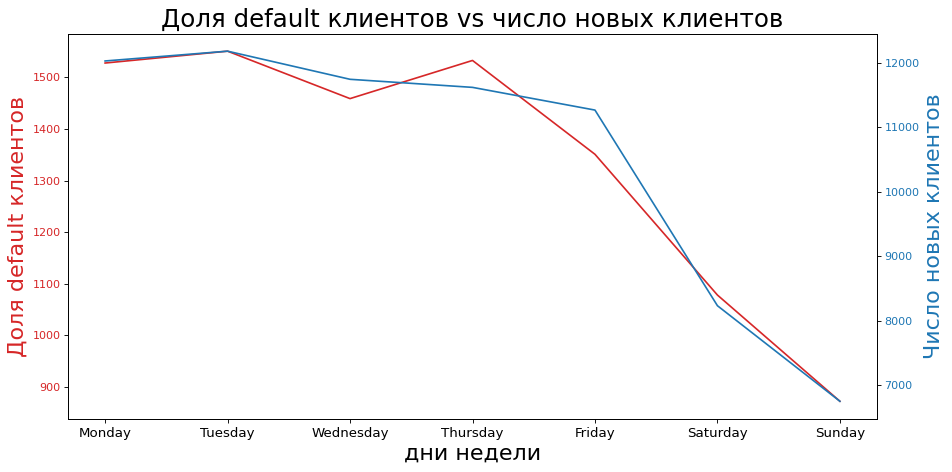

In [20]:
x = calc_proportion_customers_df2['weekday']
y1 = calc_proportion_customers_df2['num_default_customers']
y2 = calc_proportion_customers_df2['num_nondefault_customers'] + calc_proportion_customers_df2['num_default_customers']

fig, ax1 = plt.subplots(1,1,figsize=(12,6), dpi= 80)
ax1.plot(x, y1, color='tab:red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('дни недели', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('Доля default клиентов', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Число новых клиентов", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title("Доля default клиентов vs число новых клиентов", fontsize=22)
fig.tight_layout()
ax2.grid(False)
ax1.grid(False)
plt.show()

Мои подозрения про выходные подтвердились, четко видно, что кредитов выдают в 1,5-2 раза меньше, и качество новых клиентов падает.  
Правда есть еще такой всплеск плохих клиентов в четверг, но тут может был какой то выброс (например одно хорошее отделение банка ушло на перобучение, а все осальные натворили дел, и тем самым испортили всю статистику).

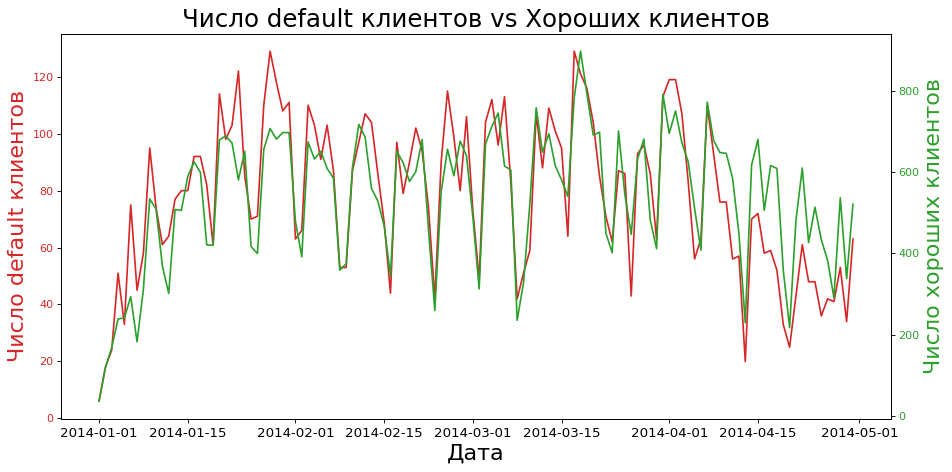

In [21]:
x = calc_proportion_customers_df['data']
y1 = calc_proportion_customers_df['num_default_customers']
y2 = calc_proportion_customers_df['num_nondefault_customers']

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(12,6), dpi= 80)
ax1.plot(x, y1, color='tab:red')

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:green')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Дата', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('Число default клиентов', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Число хороших клиентов", color='tab:green', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.set_title("Число default клиентов vs Хороших клиентов", fontsize=22)
fig.tight_layout()
ax2.grid(False)
ax1.grid(False)
plt.show()

Судя по графику, что-то поменялось в работе банка с середины марта - плохих кредитов стало меньше.

Получается, что у нас данные за полных первых четырех месяцев 2014 года.

Идея! Можно создать доп признаки: месяц подачи заявления на кредит (будет 4 признака) и признак подача была в месяц когда подали максимальное количество заявлений.  

ПС. Чуть позже придумал сделать тоже самое и для просрочки выплат. и тут пришел новый признак - рейтинг по подачам на кредит (не номер месяца, а номер в рейтинге в каком месяце было больше подач на кредит).

In [22]:
# отдельная функция для построения графика (сделал просто для сокращения основной функции)
def plt_graf(df_4):
    plt.figure(figsize=(5,4))
    labels = df_4['month_app']
    y1 = df_4['num_app']
    y2 = df_4['num_def_app']

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(1,1,figsize=(9,6), dpi= 80)

    rects1 = ax.bar(x - width/2, y1, width)
    ax1 = ax.twinx()
    rects2 = ax1.bar(x + width/2, y2, width,color='orange')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Месяцы')
    ax.set_ylabel('Число клиентов')
    ax1.set_ylabel('Число default клиентов')
    ax.set_title('Клиенты по месяцам')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax.bar_label(rects1, padding=3)
    ax1.bar_label(rects2, padding=3)
    
#     ax.set_facecolor(None)
#     ax1.set_facecolor(None)

    fig.tight_layout()
    fig.legend(['число клиентов', 'число default клиентов'],loc='upper right', bbox_to_anchor=(0.95, 0.95))
    ax.grid(False)
    ax1.grid(False)
#     fig.set_facecolor(color='white')
#     ax.set_facecolor('lightgrey')
#     ax1.set_facecolor('lightgrey')
#     fig.grid()

    
#     ax.spines["top"].set_visible(True)
#     ax.spines["right"].set_visible(True)
#     ax.spines["bottom"].set_visible(True)
    plt.show()

In [89]:
def get_new_cats_for_date(data):
    print(datetime.datetime.now(),', get_new_cats_for_date:','старт выполнения функции')
    # посмотрим на разброс дат в данных
    data_from = data.app_date.min()
    data_to = data.app_date.max()
#     print('Минимальная дата:',data_start,'\nМаксимальная дата:', data_end)
    
    # создадим признак по давности подачи заявления от последнего поданного
    data['days_ago'] = (data_to-data.app_date).dt.days.astype('int')
    print(datetime.datetime.now(),', get_new_cats_for_date:','создан признак days_ago (давность подачи заявления от последнего поданного)')
    # создадим признак days_from по давности подачи заявления от первого дня подачи
    data['days_from'] = ((data.app_date-data_from).dt.days.astype('int')**2)
    print(datetime.datetime.now(),', get_new_cats_for_date:','создан признак days_from (через сколько было подано заявление после первой подачи)')
    
    # создадим признак номер месяца подачи заявления
    data['month_app'] = pd.DatetimeIndex(data['app_date']).month
    print(datetime.datetime.now(),', get_new_cats_for_date:','создан признак month_app (номер месяца подачи заявления)')
    
    # посчитаем ранг месяца по подачам заявлений
    df_2 = pd.DataFrame(data['month_app'].value_counts())
    df_2['month_app_rang'] = range(1, len(df_2) + 1)
        
    # Новая идея, а в какой месяц было больше все отказов по выплатам кредита?  
    # Признаки можно сделать аналогичные подачи заявлений: 4 столбца с рейтингом месяца по просрочке и месяц с максимальной просрочкой.
    
    # добавляем ранг месяца по подачам заявлений
    df_3=pd.DataFrame(data[(data['default']==1)].groupby(['month_app'],as_index=False)[['app_date']].count())
    df_3=df_3.sort_values("app_date", axis = 0, ascending = False)
    df_3['month_default_rang'] = range(1, len(df_2) + 1)
    
    print(datetime.datetime.now(),', get_new_cats_for_date:','рассчитываем новые признаки: month_app_rang, month_default_rang, prc_bad_clients, month_of_max_app, month_of_max_def')
    
    df_2.rename(columns={'month_app':'num_app'},inplace=True)
    df_2['month_app']=df_2.index
    df_3.rename(columns={'app_date':'num_def_app'},inplace=True)
    df_4=df_2.merge(df_3, left_on='month_app',right_on='month_app')
    df_4.sort_values(by='month_app', inplace=True)
    
    # добавим новый признак сначала в df_4
    df_4['prc_bad_clients']=round(df_4.num_def_app/df_4.num_app*100,2)
    
    month_of_max_app = df_4.loc[df_4['num_app'] == df_4['num_app'].max(), 'month_app'].iloc[0]
    month_of_max_def = df_4.loc[df_4['num_def_app'] == df_4['num_def_app'].max(), 'month_app'].iloc[0]

    df_4['month_of_max_app'] = df_4['month_app'].apply(lambda x: 1 if x == month_of_max_app else 0)
    df_4['month_of_max_def'] = df_4['month_app'].apply(lambda x: 1 if x == month_of_max_def else 0)
    
    df_4_graf=df_4.copy()
    df_4.drop(columns={'num_app','num_def_app'} ,inplace=True)
    print(datetime.datetime.now(),', get_new_cats_for_date:','рассчитали новые признаки')

    # объединяем с рабочим датасетом
#     data=pd.merge(data,df_4, left_on='month_app', right_on='month_app')
#     print(datetime.datetime.now(),', get_new_cats_for_date:','добавили новые признаки в рабочий датасет')
    
    # выведем график числа клиентов и число default клиентов по месяцам    
    plt_graf(df_4_graf)
    
    
# -----------------------------------------------------------------------------------------------------------------------------------------------------
#  код ниже оставил для истории - как не надо делать.
#  код рабочий, но время выполнения большое
#  до смешного --- код пришлось вернуть назад в обработку, тк что-то я не то делаю при использовании merge
#  второй проект подряд, где он мне сильно портит жизнь (потратил кучу времени на разбор причин низких результатов при подтверждении)

    # запишем ранг месяца по подачам заявлений в наш набор данных
    data['month_app_rang']=data['month_app'].apply(lambda x: df_2['month_app_rang'].loc[x])
    print(datetime.datetime.now(),', get_new_cats_for_date:','создан признак month_app_rang (ранг месяца по подачам заявлений [меньше=лучше])')
    
    # добавим признак подачи в месяц с максимальным числом подачи заявлений на кредит
    month_of_max_app = data['month_app'].value_counts().index[0]
    data['month_of_max_app'] = data['month_app'].apply(lambda x: 1 if x==month_of_max_app else 0)
    print(datetime.datetime.now(),', get_new_cats_for_date:','создан признак month_of_max_app (подачи в месяц с максимальным числом подачи заявлений на кредит [0/1])')
    
    # запишем ранг месяца по просрочке кредитов в наш набор данных
#     data['month_default_rang']=data['month_app'].apply(lambda x: df_3['month_default_rang'].loc[x-1])
#     df_4.loc[df_4['month_app']==3, 'prc_bad_clients'].iloc[0]
    data['month_default_rang']=data['month_app'].apply(lambda x: df_3.loc[df_3['month_app']==x, 'month_default_rang'].iloc[0])
    print(datetime.datetime.now(),', get_new_cats_for_date:','создан признак month_default_rang (ранг месяца по по просрочке кредитов [меньше=хуже])')

    # а теперь в основной датасет data
    data['prc_bad_clients']=data['month_app'].apply(lambda x: df_4.loc[df_4['month_app']==x, 'prc_bad_clients'].iloc[0])
    print(datetime.datetime.now(),', get_new_cats_for_date:','создан признак prc_bad_clients (доля default клиентов в месяц подачи app [меньше=лучше])')

    
    # Получается, что худший месяц для банка не там где было в абсолюте больше всего дефолтов (как я хотел изначально сделать), 
    # а там где доля дефолтов в выдаче новых кредитов была максимальной - а это в первом месяце.  
    # Добавим новый бинарный признак худшего месяца исходя из этого (те для 1 месяца будет 1, иначе 0).
    month_of_default = df_4.loc[df_4['prc_bad_clients'].idxmax(), 'month_app']
    data['month_of_max_def'] = data['month_app'].apply(lambda x: 1 if x == month_of_default else 0)
    print(datetime.datetime.now(),', get_new_cats_for_date:','создан признак month_of_max_def (месяц с максимальным числом default по кредитам [0/1])')
    
    print(datetime.datetime.now(),', get_new_cats_for_date:','конец выполнения функции')
    
    return data,df_4,df_4_graf


# -----------------------------------------------------------------------------------------------------------------------------------------------------           

In [24]:
# функция по отрисовке графиков-гистограмм
def hist_plot(columns):
    cols = plt.cm.nipy_spectral(np.arange(8,255,25))
    
    fig, axes = plt.subplots(4,2,figsize=(20,10))
    for index, column in enumerate(columns):
        ax = axes.flatten()[index]
        ax.hist(data[column],bins=50, label=column, fc=cols[index])
        ax.legend(loc='upper right')
        ax.set_ylim((0,1.05*ax.get_ylim()[1])) #установим верхнюю границы по y [0,max+5%]
        ax.set_xlim(1.05*ax.get_xlim()[0],1.05*ax.get_xlim()[1])
    fig.suptitle('Hists for num_cols')
    plt.show()

Идея! на утро пришла идея развить эти признаки и сделать еще в разрезе недель и дней недели (а не только по месяцам) - оставлю пока про запас.

"+" если были бы немного персональных данных о клиентах типа имени и даты рождения можно было бы еще и по ним сделать аналогичные признаки

Число пропусков: 0


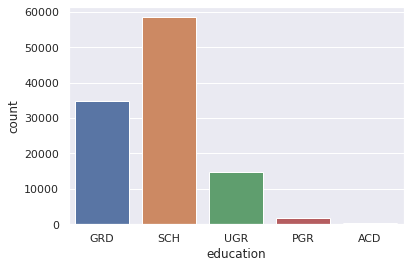

In [25]:
# Перейдем к признаку education
sns.set_theme(style="darkgrid")
plt.figure(figsize=(6,4))
ax = sns.countplot(x="education", data=data)

print('Число пропусков:',data.education.isna().sum())

## Начнем EDA

2021-09-15 07:54:57.438201 , pred_processing: старт выполнения функции
2021-09-15 07:54:57.767506 , pred_processing: данные загружены
2021-09-15 07:54:57.816817 , pred_processing: данные объединены
2021-09-15 07:54:57.845967 , pred_processing: формат даты изменен
2021-09-15 07:54:57.860046 , pred_processing: заполнены пропуски в признаке education
2021-09-15 07:54:57.860215 , pred_processing: созданы списки признаков
2021-09-15 07:54:57.860310 , pred_processing: Нераспределенные признаки по спискам: {'sample', 'app_date', 'client_id', 'default'}
2021-09-15 07:54:57.873413 , pred_processing: количество дублей в данных: 0
2021-09-15 07:54:57.873641 , pred_processing: конец выполнения функции
2021-09-15 07:54:57.875486 , get_new_cats_for_date: старт выполнения функции
2021-09-15 07:54:57.882900 , get_new_cats_for_date: создан признак days_ago (давность подачи заявления от последнего поданного)
2021-09-15 07:54:57.888099 , get_new_cats_for_date: создан признак days_from (через сколько было

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

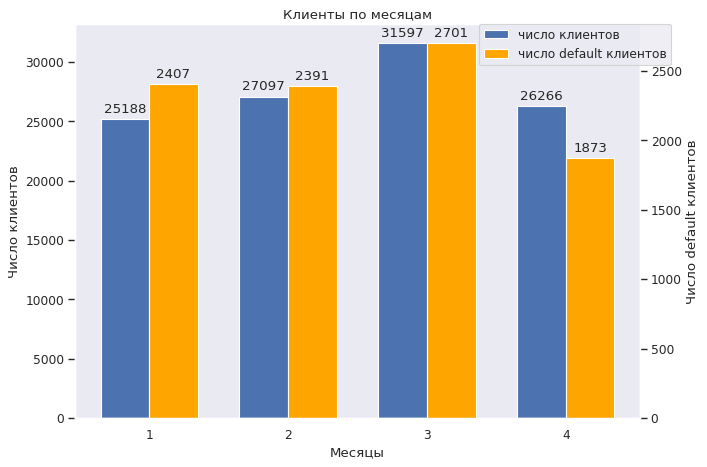

2021-09-15 07:55:00.645802 , get_new_cats_for_date: создан признак month_app_rang (ранг месяца по подачам заявлений [меньше=лучше])
2021-09-15 07:55:00.749408 , get_new_cats_for_date: создан признак month_of_max_app (подачи в месяц с максимальным числом подачи заявлений на кредит [0/1])
2021-09-15 07:55:26.967800 , get_new_cats_for_date: создан признак month_default_rang (ранг месяца по по просрочке кредитов [меньше=хуже])
2021-09-15 07:55:53.133962 , get_new_cats_for_date: создан признак prc_bad_clients (доля default клиентов в месяц подачи app [меньше=лучше])
2021-09-15 07:55:53.237347 , get_new_cats_for_date: создан признак month_of_max_def (месяц с максимальным числом default по кредитам [0/1])
2021-09-15 07:55:53.237560 , get_new_cats_for_date: конец выполнения функции


In [126]:
# загрузим и предобработаем данные заново
plt.figure(figsize=(5,4))
data,bin_cols,cat_cols,num_cols,names = pred_processing()
data,df_4,df_4_graf=get_new_cats_for_date(data)
# data=get_new_cats_for_date(data)

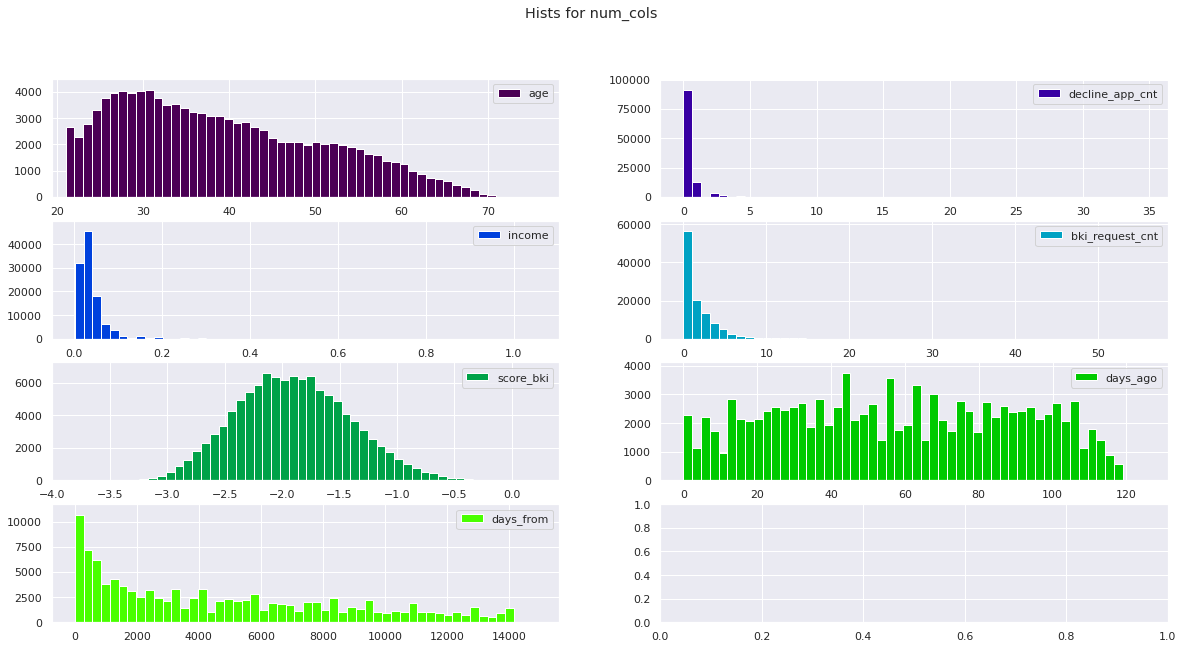

In [127]:
df_stats=get_stats(data)
hist_plot(num_cols)

In [128]:
df_stats.loc['income'].T

Значение признака                                       доход заёмщика
unique7              [50000, 5000, 30000, 17000, 120000, 11000, 80000]
type_field                                                       int64
nunique                                                           1207
not_fill_number                                                      0
count                                                         110148.0
mean                                                      41012.648537
std                                                       45399.735051
min                                                             1000.0
25%                                                            20000.0
50%                                                            30000.0
75%                                                            48000.0
max                                                          1000000.0
most_freq_value                                                  32000
Name: 

Как видно из графика и из таблицы статистики признак 'income' имеетслишком большой разброс - от 1 000 до 1 000 000.  
Это исправит логарифмирование данных.

In [129]:
# прологарифмуем сразу несколько признаков
for i in ['income','bki_request_cnt','age']:
    data[i] = np.log(data[i] + 1)

In [130]:
# посмотрим на гругие числовые признаки на предмет выбросов

# вычислим IQR
Q1 = data[num_cols].quantile(0.25)
Q3 = data[num_cols].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

age                   0.457833
decline_app_cnt       0.000000
income                0.875440
bki_request_cnt       1.386294
score_bki             0.692546
days_ago             56.000000
days_from          6832.000000
dtype: float64


In [131]:
# вычислим количество выбросов
data[num_cols][(data[num_cols] < (Q1 - 1.5 * IQR)) |(data[num_cols] > (Q3 + 1.5 * IQR))].count()

age                    0
decline_app_cnt    18677
income              2609
bki_request_cnt       15
score_bki            518
days_ago               0
days_from              0
dtype: int64

Из всех признаков только 'income' и 'bki_request_cnt' необходимо привести в порядок, тк другие столбцы статистические.

<AxesSubplot:xlabel='default', ylabel='income'>

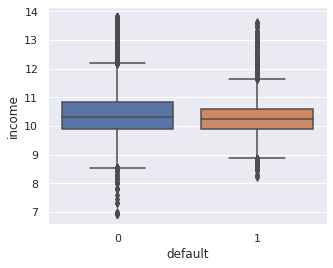

In [132]:
# посмотрим боксплот по доходам
plt.figure(figsize=(5,4))
sns.boxplot(x="default", y='income', data=data[data['default']!=999])

In [133]:
# как видно из графика - выбросы у нас и сверху и снизу.
#  замена значений будет на медианное значение

# сначала снизу
low_out = (Q1.income - 1.5 * IQR.income)
income_low_out = (data['income'] < low_out)
data.loc[income_low_out,'income'] = data.income.median()

# теперь сделаем аналогично для выбросов сверху
high_out = (Q3.income + 1.5 * IQR.income)
income_high_out = (data['income'] > high_out)
data.loc[income_high_out,'income'] = data.income.median()

In [134]:
# заполним выбросы в столбце bki_request_cnt средним значением
bki_request_cnt_high_out = (data['bki_request_cnt'] > (Q3.bki_request_cnt + 1.5 * IQR.bki_request_cnt))
data.loc[bki_request_cnt_high_out,'bki_request_cnt'] = data.bki_request_cnt.mean()

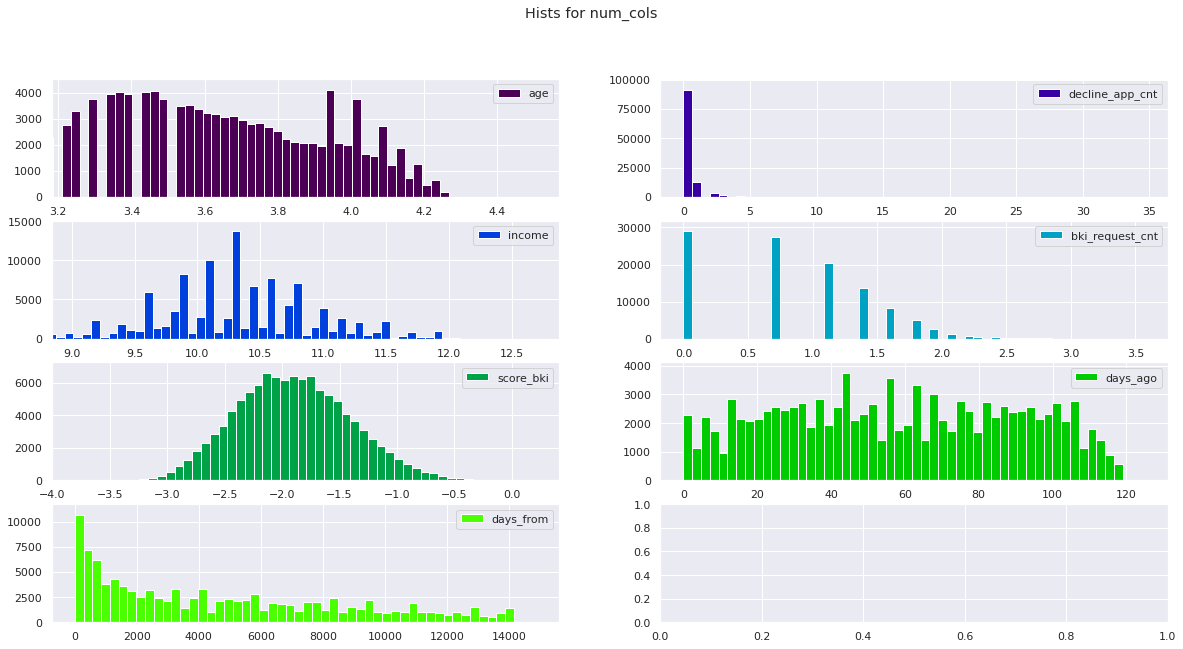

In [135]:
# и снова посмотрим на графики
hist_plot(num_cols)

<AxesSubplot:>

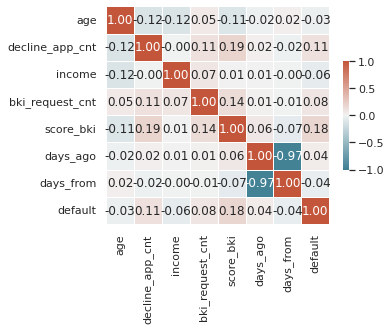

In [136]:
# теперь посчитаем матрицу корреляций
plt.figure(figsize=(5,4))
corr_num_cols=data[data['sample'] == 1][num_cols+['default']].corr()
sns.heatmap(corr_num_cols, annot=True, fmt='.2f',cmap=sns.diverging_palette(220, 20, as_cmap=True), 
            vmax=1, vmin=-1, cbar_kws={"shrink": .5},linewidths=.5)

В целом получается зависимости численных признаков от целевой переменной слабые.  
Поэтому я их оставлю все для модели

<AxesSubplot:>

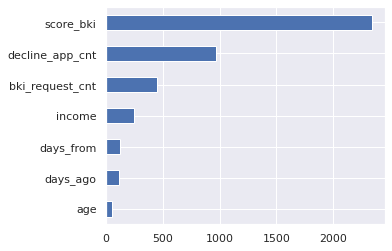

In [137]:
# посмотрим на значимость числовых признаков
plt.figure(figsize=(5,4))
dk = pd.Series(f_classif(data[data['sample']==1][num_cols], data[data['sample']==1]['default'])[0], index = num_cols)
dk.sort_values(inplace = True)
dk.plot(kind = 'barh')

Как видим значимыми признаками являются 'score_bki' и 'decline_app_cnt'.  

## Обработка бинарных и категориальных признаков

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

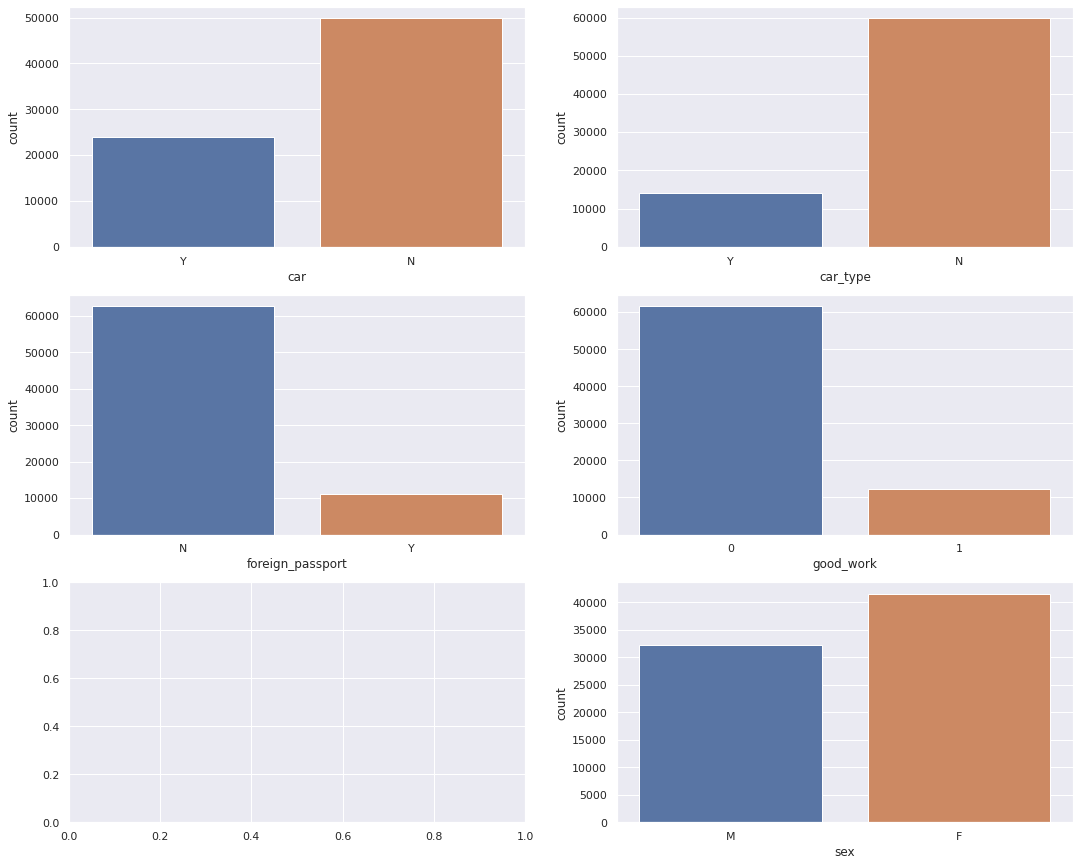

In [139]:
# Посмотрим на распределения бинарных признаков:
fig, axes = plt.subplots(3, 2, figsize=(18,15))
for i,col in enumerate(bin_cols):
    sns.countplot(data[data['sample']==1][col], ax=axes.flat[i-1]);

In [140]:
# с помощью LabelEncoder закодируем бинарные признаки 
label_encoder = LabelEncoder()
for item in bin_cols:
    data[item] = label_encoder.fit_transform(data[item])  
    
# посмотрим на результат    
data[bin_cols].sample(5)

,sex,car,car_type,foreign_passport,good_work
10964,1,0,0,0,0
87699,0,0,0,0,0
64482,1,1,0,0,0
103485,0,0,0,0,0
35515,1,0,0,0,0


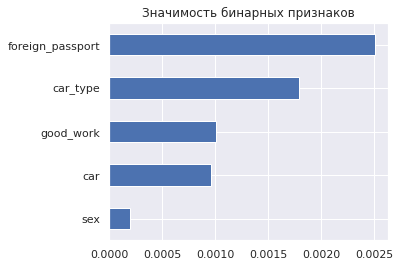

In [141]:
# посмотрим на важность бинарных признаков для модели
bin_cat = pd.Series(mutual_info_classif(data[data['sample']==1][bin_cols], data[data['sample']==1]['default'],
                                    discrete_features =True), index = bin_cols)
bin_cat.sort_values(inplace = True)
plt.figure(figsize=(5,4))
bin_cat.plot(kind = 'barh')
plt.title('Значимость бинарных признаков')
plt.show()

как видим из графика пол практически не влияет на модель - этот признак кандидат на удаление из набора данных для модели.  

### перейдем к категориальным признакам

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

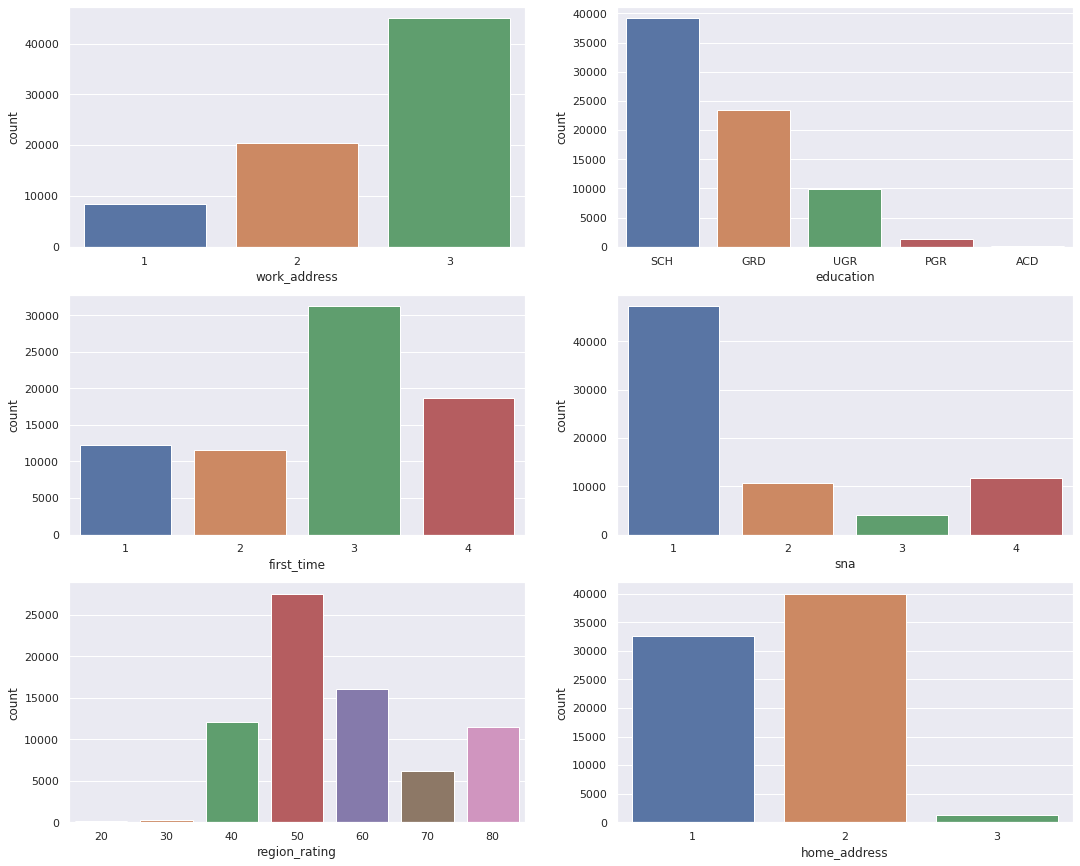

In [142]:
# Посмотрим на распределения бинарных признаков:
fig, axes = plt.subplots(3, 2, figsize=(18,15))
for i,col in enumerate(cat_cols):
    sns.countplot(data[data['sample']==1][col], ax=axes.flat[i-1]);

In [143]:
# поработаем с decline_app_cnt
print(data['decline_app_cnt'].value_counts())

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
21        1
30        1
20        1
19        1
22        1
33        1
15        1
24        1
Name: decline_app_cnt, dtype: int64


In [144]:
# переведем decline_app_cnt в категориальный признак, тк основные группы (с числом записей >100) это первые 7.
data['decline_app_cnt'] = data['decline_app_cnt'].apply(lambda x: 6 if x>=6 else x)

cat_cols.append('decline_app_cnt')
num_cols.remove('decline_app_cnt')

In [145]:
#создадим dummy-переменные для категориальных признаков
data_dumm=pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

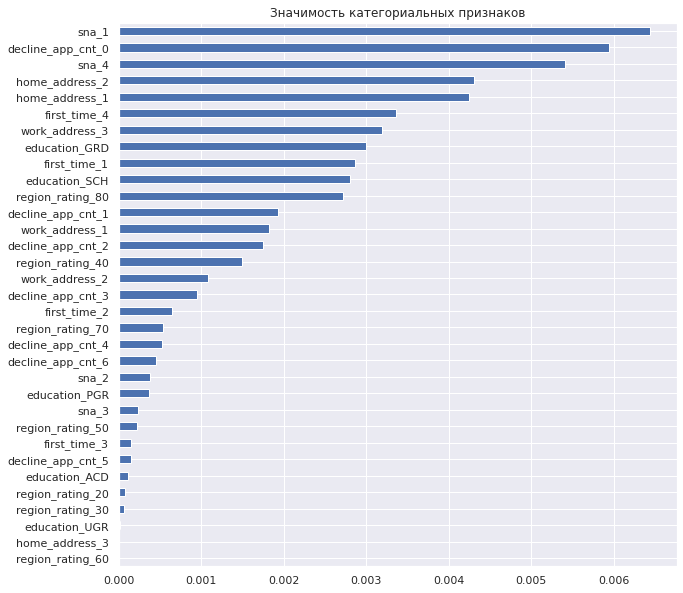

In [147]:
# посмотрим на важность категориальных признаков для модели
cat_cols2=list(set(data_dumm.columns)-set(data.columns))

data2=data_dumm.copy()
cat_cat = pd.Series(mutual_info_classif(data2[data2['sample']==1][cat_cols2], 
                                        data2[data2['sample']==1]['default'],
                                        discrete_features =True), index = cat_cols2)
cat_cat.sort_values(inplace = True)
plt.figure(figsize=(10,10))
cat_cat.plot(kind = 'barh')
plt.title('Значимость категориальных признаков')
plt.show()
data=data2.copy()

In [149]:
# произведем отбор признаков для моделирования
cats_to_model=bin_cols+cat_cols2+num_cols

# исключим из модели нижний хвост признаков, который ни на что не влияет
cat_cat.index[0:6].to_list()

['region_rating_60',
 'home_address_3',
 'education_UGR',
 'region_rating_30',
 'region_rating_20',
 'education_ACD']

In [152]:
# list_del_cols =list(['days_ago','month_app','month_app_rang','month_default_rang',
#                   'prc_bad_clients','month_of_max_app','month_of_max_def'])
list_del_cols =list([])
list_del_cols_2 = list(cat_cat.index[0:5])

list_del_cols.extend(list_del_cols_2)

print('Список признаков на исключение из моделирования:',list_del_cols)

for i in list_del_cols:
    if i in cats_to_model:
        cats_to_model.remove(i)
    if i in num_cols:
        num_cols.remove(i)
    if i in data.columns:
        data.drop(columns=[i], inplace=True)

# разделим обратно данные на тестовую и обучающую части
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

['region_rating_60', 'home_address_3', 'education_UGR', 'region_rating_30', 'region_rating_20']


In [153]:
# нормализуем числовые признаки
ssc = StandardScaler()
ssc.fit(train_data[num_cols].values)
X_num = ssc.transform(train_data[num_cols].values)

# выделим признаки и таргет
X = np.hstack([X_num, train_data[cats_to_model].values])
Y = train_data['default'].values

# сформируем тестовую выборку
X_num_t = ssc.transform(test_data[num_cols].values)
X_test_t = np.hstack([X_num_t, test_data[cats_to_model].values])

# посмотрим на распределение целевой переменной
train_data['default'].value_counts(normalize=True)

0    0.873006
1    0.126994
Name: default, dtype: float64

Данные получились немного несбалонсированными (несбалансированными данными считаются данные, где соотношение более чем 1:10), и количество положительных сильно меньше отрицательных.   

## Построение модели

AUC: 0.738784

### Confusion matrix ###############################################



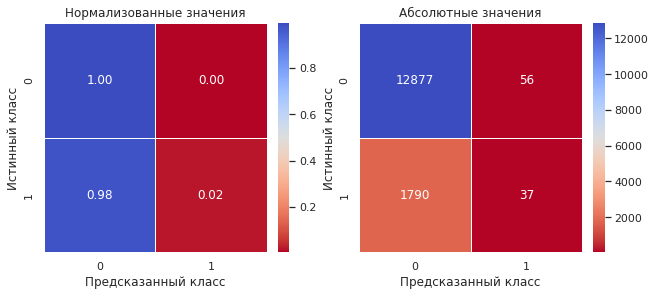

### Classification Report ##########################################

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12933
           1       0.40      0.02      0.04      1827

    accuracy                           0.87     14760
   macro avg       0.64      0.51      0.49     14760
weighted avg       0.82      0.87      0.82     14760

####################################################################


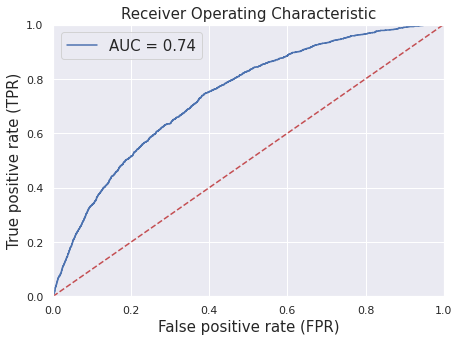

In [155]:
# для начала построим модель логистической регресии с параметрами по умолчанию, не учитывая несбалансированность классов

# разделим данные на обучающую и тестовую выборки
# у нас более 100тыс записей - поэтому нам хватит 20% на тестовую часть.
X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED)

model = LogisticRegression(max_iter=500, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

probs = model.predict_proba(x_test)[:,1]
pred = model.predict(x_test)

# выведем результаты моделирования
print('AUC: %.6f' % roc_auc_score(y_test,probs))
result_modelling(y_test,pred)

## Выводы по confusion matrix

На текущей модели получилась большая доля ложно-положительных значений.
Для банка это также плохо, это приводит к недополученной прибыли.

Можно попробовать оптимизировать модель путем подбора параметров регрессии.

## Оптимизация гиперпараметров

Поскольку на Каггле всё очень медленно отрабатывает,  
то я запускаю один раз подбор параметров -   
а затем фиксирую лучшие параметры для перерасчета в ускоренном варианте (блоком ниже).

In [58]:
# попробуем оптимизировать параметры модели, используя GridSearch и KFold cross validation

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
logreg = LogisticRegression()
param = {"C": [0.01,0.05,0.1,0.2, 0.3, 0.5,1,1.5],     #np.arange(0,10,1), 
         "class_weight": ['balanced'], 
         "max_iter": [100,250,500],                    #range(100,1100,250), 
         "penalty": ["l1"],                            #"l2",
         "solver": ["liblinear"]}
sc='roc_auc'

gscv = GridSearchCV(logreg, param, scoring=sc, refit=True, cv=skf)
gscv.fit(X_train,y_train)
print(gscv.best_params_)

{'C': 0.2, 'class_weight': 'balanced', 'max_iter': 250, 'penalty': 'l1', 'solver': 'liblinear'}


ниже блок без вариантов по перебору параметров.   
Подбор параметров дал результат:  
**{'C': 0.2, 'class_weight': 'balanced', 'max_iter': 250, 'penalty': 'l1', 'solver': 'liblinear'}**

In [157]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
logreg = LogisticRegression()
param = {"C": [0.2],                            
         "class_weight": ['balanced'], 
         "max_iter": [250],                     
         "penalty": ["l1"],                    
         "solver": ["liblinear"]}
sc='roc_auc'

gscv = GridSearchCV(logreg, param, scoring=sc, refit=True, cv=skf)
gscv.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.2], 'class_weight': ['balanced'],
                         'max_iter': [250], 'penalty': ['l1'],
                         'solver': ['liblinear']},
             scoring='roc_auc')

AUC: 0.744745

### Confusion matrix ###############################################



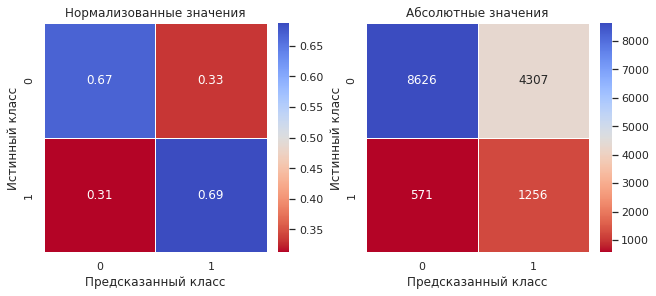

### Classification Report ##########################################

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.23      0.69      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760

####################################################################


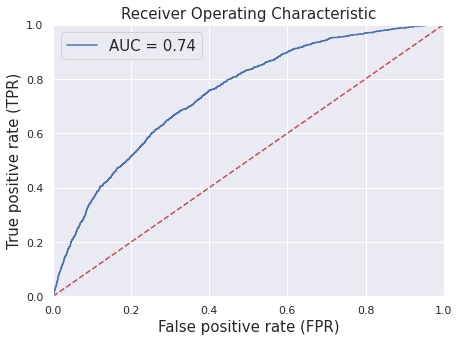

In [158]:
# построим confusion matrix и посчитаем AUC
probs = gscv.predict_proba(x_test)[:,1]
pred = gscv.predict(x_test)

# выведем результаты моделирования
print('AUC: %.6f' % roc_auc_score(y_test,probs))
result_modelling(y_test,pred)

**Выводы по confusion matrix**  

значение AUC уменьшилось не много, зато удалось значительно уменьшить долю ложно-положительных предсказаний.
По результатам подбора гиперпараметров получилось следующее:  
1. Увеличить Recall для ложно-положительных клиентов с 0.02 до 0.69
2. Увеличить f1-score для ложно-положительных клиентов c 0.04 до 0.34
3. Но уменьшили Recall для ложно-отрицательных клиентов с 1.00 до 0.67
4. Но уменьшили f1-score для ложно-отрицательных клиентов c 0.93 до 0.78

Зато значительно уменьшили риски банка по выдаче ненадежным клиентам.

## подбор параметров через RandomizedSearchCV

In [65]:
# попробуем оптимизировать гиперпараметры через RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
logreg = LogisticRegression()
param = {"C": np.arange(0.01,5,1), 
         "class_weight": ["balanced"], 
         "max_iter": range(100,500,100), 
         "penalty": ["l1"], 
         "solver": ["liblinear"]}
rscv = RandomizedSearchCV(logreg, param, scoring='roc_auc', refit=True, cv=skf)
rscv.fit(X_train,y_train)
print(rscv.best_params_)

{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 200, 'class_weight': 'balanced', 'C': 1.01}


rscv = RandomizedSearchCV(logreg, param, scoring='roc_auc', refit=True, cv=skf, verbose=0)  
{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'class_weight': 'balanced', 'C': 1.01}

In [159]:
# попробуем оптимизировать гиперпараметры через RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
logreg = LogisticRegression()
param = {"C": [1.01], 
         "class_weight": ["balanced"], 
         "max_iter": [200], 
         "penalty": ["l1"], 
         "solver": ["liblinear"]}
rscv = RandomizedSearchCV(logreg, param, scoring='roc_auc', refit=True, cv=skf)
rscv.fit(X_train,y_train)
print(rscv.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 200, 'class_weight': 'balanced', 'C': 1.01}


AUC: 0.744702

### Confusion matrix ###############################################



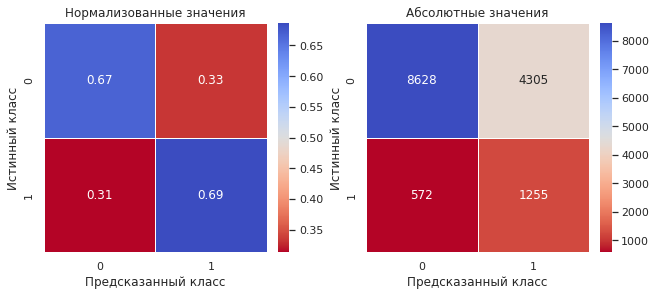

### Classification Report ##########################################

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.23      0.69      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760

####################################################################


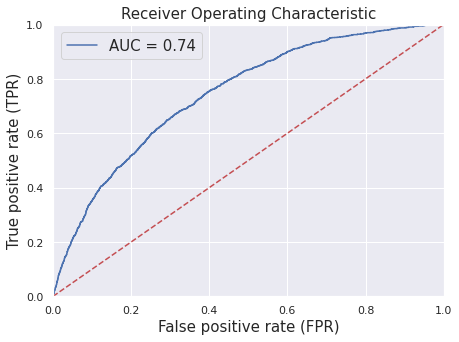

In [160]:
# построим confusion matrix и посчитаем AUC
probs = rscv.predict_proba(x_test)[:,1]
pred = rscv.predict(x_test)

# выведем результаты моделирования
print('AUC: %.6f' % roc_auc_score(y_test,probs))
result_modelling(y_test,pred)

## Выводы:  
Мне понравилось использовать RandomizedSearchCV (правда делал я это на своём ноутбуке локально в jupyter-е).  
Данный метод работает в разы быстрее чем GridSearchCV при сопоставимых результатах в предсказании default клиентов.

## Submission

In [60]:
# сформируем тестовую выборку
X_num_t = ssc.transform(test_data[num_cols].values)
X_test_t = np.hstack([X_num_t, test_data[cats_to_model].values])

### 1. Вариант подтверждения для модели без подбора гиперпараметров

In [62]:
print('Submission начат...')

submit = pd.DataFrame(df_test.client_id)
submit['default']=model.predict_proba(X_test_t)[:,1]

display(submit.sample(10))
submit.to_csv('submission_model.csv', index=False)

print('Файл сохранен')

Submission начат...


,client_id,default
27249,83643,0.093912
1554,8694,0.184916
4665,93694,0.251324
11639,105605,0.014714
10936,92801,0.095172
2058,40288,0.258317
11261,60800,0.100501
1918,106218,0.080393
3385,45406,0.040519
34938,34111,0.047979


Файл сохранен


### 2. Вариант подтверждения для модели с подбором гиперпараметров (GridSearchCV)

In [161]:
print('Submission начат...')

submit = pd.DataFrame(df_test.client_id)
submit['default']=gscv.predict_proba(X_test_t)[:,1]

display(submit.sample(10))
submit.to_csv('submission_gscv.csv', index=False)
print('Файл сохранен')

Submission начат...


,client_id,default
26451,76663,0.368430
27968,70095,0.154315
7878,19530,0.635489
8267,91247,0.172777
21534,14523,0.262892
27746,40071,0.719710
23505,94524,0.303389
1050,467,0.439365
29854,97905,0.180127
13889,61419,0.388847


Файл сохранен


### 3. Вариант подтверждения для модели с подбором гиперпараметров (RandomizedSearchCV)

In [67]:
print('Submission начат...')

submit = pd.DataFrame(df_test.client_id)
submit['default']=rscv.predict_proba(X_test_t)[:,1]

display(submit.sample(10))
submit.to_csv('submission_rscv.csv', index=False)
print('Файл сохранен')

Submission начат...


,client_id,default
31174,19970,0.373656
17030,37838,0.513200
161,100867,0.447420
6112,12767,0.474724
7023,107013,0.396626
6088,74987,0.504437
9787,65768,0.278144
19105,93249,0.210601
18710,71473,0.120494
25253,82592,0.354915


Файл сохранен
